<a href="https://colab.research.google.com/github/vadhri/hpc-notebook/blob/main/pde_fft_1d_heat_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Solving PDE with FFT.

PDE = Heat equation

$$
\frac{∂T(x,t)}{∂t}  = \alpha.\frac{∂^2T(x,t)}{∂x^2}
$$


In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Define spatial domain

# Length of the domain
# Number of grid points
# Grid spacing
L = 2 * np.pi
N = 64
dx = L / N

# Spatial grid points
x = np.linspace(0, L, N, endpoint=False)

# Define time parameters
# Thermal diffusivity
# Time step
# Total time for simulation
# Number of time steps

alpha = 0.01
dt = 0.01
t_final = 1
num_steps = int(t_final / dt)


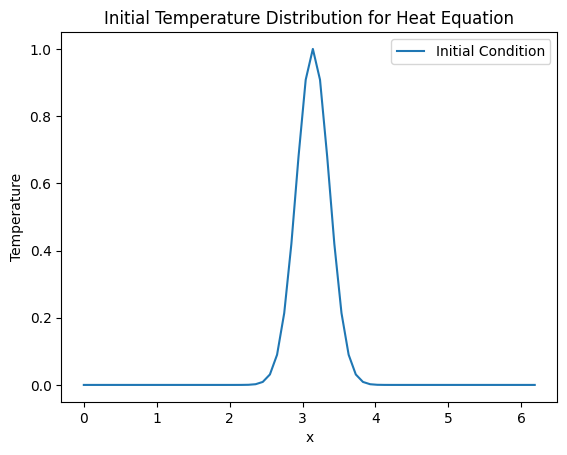

In [70]:
# Initial condition: A Gaussian heat distribution centered at x = pi
u0 = np.exp(-((x - np.pi) ** 2) / 0.1)

# Plot the initial condition
plt.plot(x, u0, label="Initial Condition")
plt.xlabel("x")
plt.ylabel("Temperature")
plt.title("Initial Temperature Distribution for Heat Equation")
plt.legend()
plt.show()


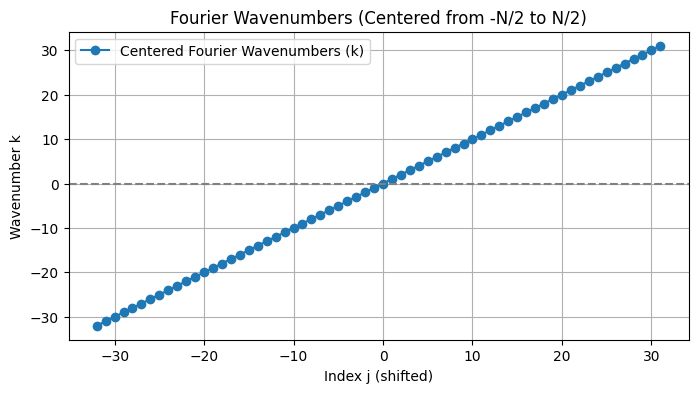

In [71]:
# Compute manually centered wavenumbers from -N/2 to N/2
k = np.zeros(N)

# First half (negative frequencies)
for j in range(N//2):
    k[j] = (2 * np.pi * (j - N//2)) / L

# Second half (positive frequencies)
for j in range(N//2, N):
    k[j] = (2 * np.pi * (j - N//2)) / L

# Compute second derivative factor in Fourier space
k2 = -k * k
plt.figure(figsize=(8, 4))
plt.plot(np.arange(-N//2, N//2), k, 'o-', label="Centered Fourier Wavenumbers (k)")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Index j (shifted)")
plt.ylabel("Wavenumber k")
plt.title("Fourier Wavenumbers (Centered from -N/2 to N/2)")
plt.legend()
plt.grid()
plt.show()


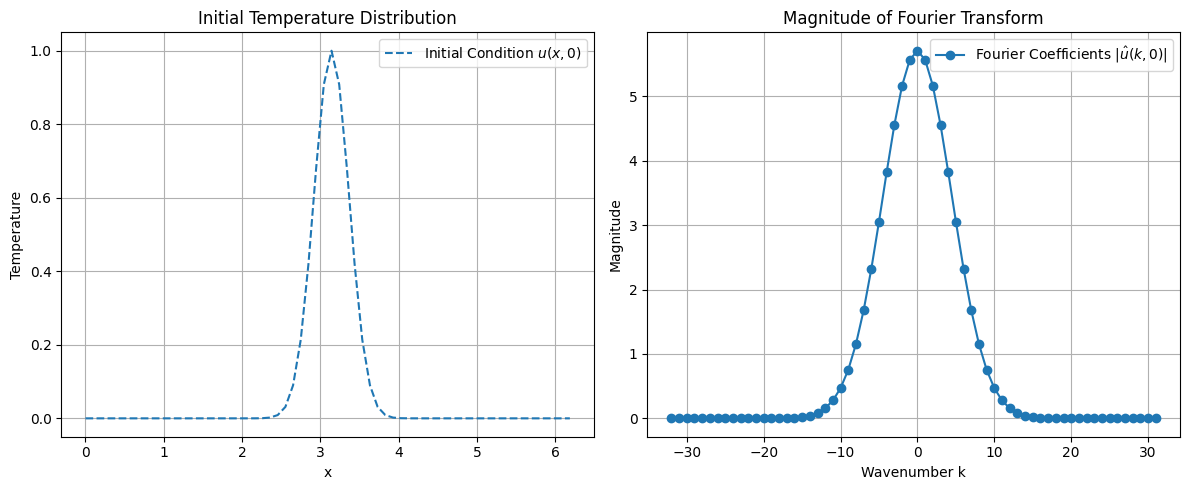

In [72]:
def fft(u):
    """Compute the Discrete Fourier Transform (DFT) manually."""
    N = len(u)
    u_hat = np.zeros(N, dtype=complex)  # Initialize Fourier coefficients
    for k in range(N):
        for n in range(N):
            exponent = -2j * np.pi * ((k - N//2) * n / N)  # Centered FFT
            u_hat[k] += u[n] * np.exp(exponent)
    return u_hat

# Compute Fourier transform of initial condition
u0_hat = fft(u0)
plt.figure(figsize=(12, 5))

# Plot Initial Condition in Real Space
plt.subplot(1, 2, 1)
plt.plot(x, u0, label="Initial Condition $u(x,0)$", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("Temperature")
plt.title("Initial Temperature Distribution")
plt.legend()
plt.grid()

# Plot FFT Magnitude
plt.subplot(1, 2, 2)
plt.plot(k, np.abs(u0_hat), 'o-', label="Fourier Coefficients $|\hat{u}(k,0)|$")
plt.xlabel("Wavenumber k")
plt.ylabel("Magnitude")
plt.title("Magnitude of Fourier Transform")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [73]:
# Apply the Heat Equation Solution

# Compute k^2 for diffusion
k2 = (2 * np.pi * k / L) ** 2  # Squared wavenumbers

# Time evolution
t_final = 2.0  # Final time

u_hat_evolved = u0_hat * np.exp(-alpha * k2 * t_final)


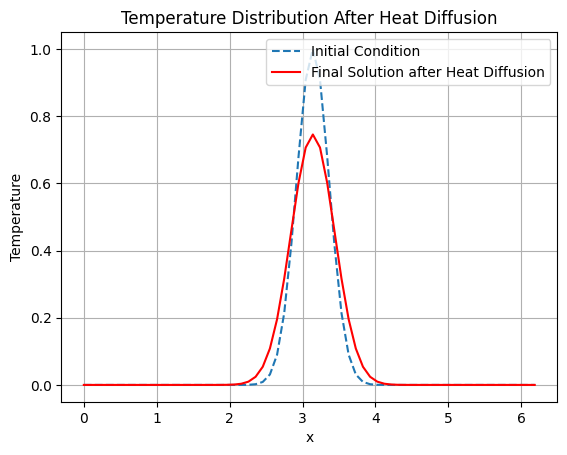

In [74]:
def ifft(u_hat):
    """Compute the Inverse Discrete Fourier Transform (IDFT) manually."""
    N = len(u_hat)
    u = np.zeros(N, dtype=complex)
    for n in range(N):
        for k in range(N):
            exponent = 2j * np.pi * ((k - N//2) * n / N)
            u[n] += u_hat[k] * np.exp(exponent)
    return u.real / N  # Normalize and take the real part

# Compute final solution in real space
u_final = ifft(u_hat_evolved)

plt.plot(x, u0, label="Initial Condition", linestyle="dashed")
plt.plot(x, u_final, label="Final Solution after Heat Diffusion", color="red")
plt.xlabel("x")
plt.ylabel("Temperature")
plt.title("Temperature Distribution After Heat Diffusion")
plt.legend()
plt.grid()
plt.show()



In [75]:
import matplotlib.animation as animation

# Compute initial Fourier transform
u0_hat = fft(u0)
k_vals = np.fft.fftfreq(N, d=dx) * 2 * np.pi  # Wavenumbers
k2 = k_vals**2
num_frames = 50

# Initialize figure
fig, ax = plt.subplots(figsize=(8, 4))
line, = ax.plot(x, u0, label="Temperature Distribution", color="red")
ax.set_xlabel("x")
ax.set_ylabel("Temperature")
ax.set_title("Heat Diffusion Over Time")
ax.legend()
ax.grid()
ax.set_ylim(0, 1.1)

# Animation update function
def update(frame):
    t = frame * dt
    u_hat_t = u0_hat * np.exp(-alpha * k2 * t)  # Apply Fourier solution
    u_t = ifft(u_hat_t)  # Convert back to real space
    line.set_ydata(u_t)  # Update plot
    ax.set_title(f"Heat Diffusion at t = {t:.2f}")
    return line,

# Create animation
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=50, blit=True)
plt.close(fig)  # Prevent duplicate static plot display

# Save the animation as a GIF
ani.save("heat_diffusion.gif", writer="pillow", fps=20)

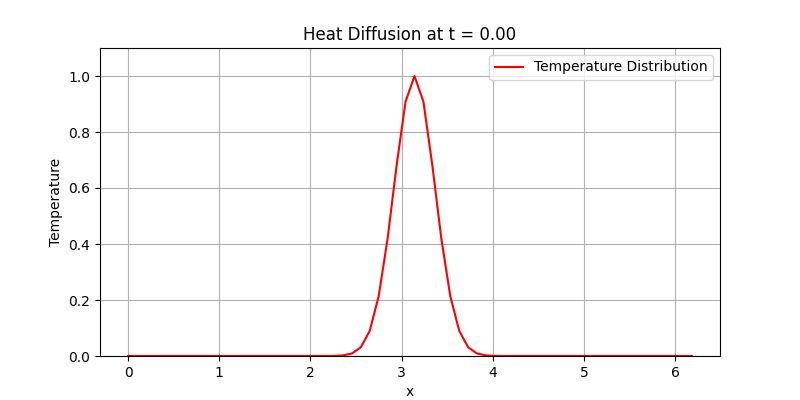

In [76]:
# prompt: display heat_diffusion.gif

from IPython.display import Image
Image('heat_diffusion.gif')


In [77]:
%%writefile heat_diffusion1d.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda_runtime.h>

#define N 256         // Number of spatial points
#define L 10.0        // Domain length
#define T_FINAL 1.0   // Final time
#define DX (L / N)    // Spatial step
#define ALPHA 0.01    // Diffusion coefficient
#define DT 0.001      // Time step
#define NSTEPS (int)(T_FINAL / DT)  // Number of time steps

// CUDA kernel for updating heat equation
__global__ void heat_kernel(double *u_new, double *u_old, double alpha, double dx, double dt) {
    int i = threadIdx.x + blockIdx.x * blockDim.x;
    if (i > 0 && i < N - 1) {  // Avoid updating boundary points
        u_new[i] = u_old[i] + alpha * dt / (dx * dx) * (u_old[i+1] - 2.0 * u_old[i] + u_old[i-1]);
    }
}

// Host function to execute CUDA
int main() {
    double *h_u, *d_u_old, *d_u_new;

    // Allocate memory on host
    h_u = (double*)malloc(N * sizeof(double));

    // Initialize spatial grid and initial condition (Gaussian pulse)
    for (int i = 0; i < N; i++) {
        double x = -L/2 + i * DX;
        h_u[i] = exp(-x * x);
    }

    // Allocate device memory
    cudaMalloc(&d_u_old, N * sizeof(double));
    cudaMalloc(&d_u_new, N * sizeof(double));

    // Copy initial data to device
    cudaMemcpy(d_u_old, h_u, N * sizeof(double), cudaMemcpyHostToDevice);

    // CUDA execution parameters
    int threadsPerBlock = 256;
    int blocksPerGrid = (N + threadsPerBlock - 1) / threadsPerBlock;

    // Time stepping loop
    for (int step = 0; step < NSTEPS; step++) {
        heat_kernel<<<blocksPerGrid, threadsPerBlock>>>(d_u_new, d_u_old, ALPHA, DX, DT);
        cudaMemcpy(d_u_old, d_u_new, N * sizeof(double), cudaMemcpyDeviceToDevice);
    }

    // Copy final result back to host
    cudaMemcpy(h_u, d_u_new, N * sizeof(double), cudaMemcpyDeviceToHost);

    // Save results
    FILE *file = fopen("heat_equation_cuda_result.txt", "w");
    for (int i = 0; i < N; i++) {
        double x = -L/2 + i * DX;
        fprintf(file, "%f %f\n", x, h_u[i]);
    }
    fclose(file);

    // Cleanup
    cudaFree(d_u_old);
    cudaFree(d_u_new);
    free(h_u);

    printf("Computation completed. Results saved.\n");
    return 0;
}


Overwriting heat_diffusion1d.cu


In [78]:
!nvcc heat_diffusion1d.cu -arch=sm_75 -o heat_diffusion1d -lm
!./heat_diffusion1d

Computation completed. Results saved.


In [79]:
%%writefile heat_diffusion1d_cufft.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda_runtime.h>
#include <cufft.h>  // Include cuFFT library

#define N 256         // Number of spatial points (must be a power of 2 for FFT)
#define L 10.0        // Domain length
#define T_FINAL 1.0   // Final time
#define ALPHA 0.01    // Diffusion coefficient
#define DT 0.1        // Time step

// Kernel to apply the time evolution in Fourier space
__global__ void time_evolution(cufftDoubleComplex *U_hat, double *k2, double alpha, double t) {
    int k = threadIdx.x + blockIdx.x * blockDim.x;
    if (k < N) {
        double decay = exp(-alpha * k2[k] * t);
        U_hat[k].x *= decay;
        U_hat[k].y *= decay;
    }
}

// Host function to execute CUDA implementation
int main() {
    double x[N], u0[N];
    cufftDoubleComplex *d_u, *d_U_hat;
    double k2[N], *d_k2;

    // Initialize spatial grid and initial condition (Gaussian pulse)
    double dx = L / N;
    for (int i = 0; i < N; i++) {
        x[i] = -L/2 + i * dx;
        u0[i] = exp(-x[i] * x[i]);  // Initial Gaussian distribution
        double k_val = (i < N/2) ? i : i - N;  // Shifted wavenumbers
        k2[i] = pow((2 * M_PI * k_val / L), 2);
    }

    // Allocate device memory
    cudaMalloc(&d_u, N * sizeof(cufftDoubleComplex));
    cudaMalloc(&d_U_hat, N * sizeof(cufftDoubleComplex));
    cudaMalloc(&d_k2, N * sizeof(double));

    // Prepare input for FFT (complex format)
    cufftDoubleComplex h_u[N];
    for (int i = 0; i < N; i++) {
        h_u[i].x = u0[i];  // Real part
        h_u[i].y = 0.0;     // Imaginary part
    }

    // Copy data to device
    cudaMemcpy(d_u, h_u, N * sizeof(cufftDoubleComplex), cudaMemcpyHostToDevice);
    cudaMemcpy(d_k2, k2, N * sizeof(double), cudaMemcpyHostToDevice);

    // Create cuFFT plan
    cufftHandle plan;
    cufftPlan1d(&plan, N, CUFFT_Z2Z, 1);

    // Perform forward FFT
    cufftExecZ2Z(plan, d_u, d_U_hat, CUFFT_FORWARD);

    // Apply time evolution in Fourier space
    time_evolution<<<1, N>>>(d_U_hat, d_k2, ALPHA, T_FINAL);
    cudaDeviceSynchronize();

    // Perform inverse FFT
    cufftExecZ2Z(plan, d_U_hat, d_u, CUFFT_INVERSE);

    // Normalize the inverse FFT result
    double scale = 1.0 / N;
    cufftDoubleComplex h_u_final[N];
    cudaMemcpy(h_u_final, d_u, N * sizeof(cufftDoubleComplex), cudaMemcpyDeviceToHost);
    for (int i = 0; i < N; i++) {
        h_u_final[i].x *= scale;  // Normalize real part
    }

    // Save results
    FILE *file = fopen("heat_equation_cuda_cufft_result.txt", "w");
    for (int i = 0; i < N; i++) {
        fprintf(file, "%f %f\n", x[i], h_u_final[i].x);
    }
    fclose(file);

    // Cleanup
    cufftDestroy(plan);
    cudaFree(d_u);
    cudaFree(d_U_hat);
    cudaFree(d_k2);

    printf("FFT-based heat equation solution completed. Results saved.\n");
    return 0;
}


Overwriting heat_diffusion1d_cufft.cu


In [80]:
!nvcc heat_diffusion1d_cufft.cu -arch=sm_75 -o heat_diffusion1d_cufft -lm -lcufft
!./heat_diffusion1d_cufft

FFT-based heat equation solution completed. Results saved.


In [81]:
%%writefile heat_diffusion1d_fft.cu

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda_runtime.h>

#define N 64
#define L 10.0
#define ALPHA 0.01
#define PI 3.141592653589793
#define NUM_FRAMES 50
#define DT 0.02

// CUDA kernel for FFT
__global__ void fft_kernel(float2 *u, float2 *U_hat, int inverse) {
    int k = threadIdx.x + blockIdx.x * blockDim.x;
    if (k >= N) return;

    float2 sum = {0, 0};
    for (int n = 0; n < N; n++) {
        float angle = 2.0f * PI * (k - N / 2) * (n - N / 2) / N;
        if (inverse) angle = -angle;
        float2 exp_term = {cos(angle), sin(angle)};
        float2 u_n = u[n];
        sum.x += u_n.x * exp_term.x - u_n.y * exp_term.y;
        sum.y += u_n.x * exp_term.y + u_n.y * exp_term.x;
    }
    if (inverse) {
        sum.x /= N;
        sum.y /= N;
    }
    U_hat[k] = sum;
}

// CUDA kernel for time evolution in Fourier space
__global__ void time_evolution(float2 *U_hat, float *k2, float dt) {
    int k = threadIdx.x + blockIdx.x * blockDim.x;
    if (k >= N) return;

    float decay = expf(-ALPHA * k2[k] * dt);
    U_hat[k].x *= decay;
    U_hat[k].y *= decay;
}

// Host function to execute the CUDA implementation
int main() {
    float x[N], u0[N];
    float2 *d_u, *d_U_hat;
    float k2[N], *d_k2;

    // Initialize spatial grid and initial condition
    float dx = L / N;
    for (int i = 0; i < N; i++) {
        x[i] = -L/2 + i * dx;
        u0[i] = exp(-x[i] * x[i]);
        float k_val = (i < N/2) ? i : i - N;
        k2[i] = powf(2 * PI * k_val / L, 2);
    }

    // Allocate device memory
    cudaMalloc(&d_u, N * sizeof(float2));
    cudaMalloc(&d_U_hat, N * sizeof(float2));
    cudaMalloc(&d_k2, N * sizeof(float));

    // Copy data to device
    float2 h_u[N];
    for (int i = 0; i < N; i++) {
        h_u[i].x = u0[i];
        h_u[i].y = 0.0f;
    }
    cudaMemcpy(d_u, h_u, N * sizeof(float2), cudaMemcpyHostToDevice);
    cudaMemcpy(d_k2, k2, N * sizeof(float), cudaMemcpyHostToDevice);

    // Perform forward FFT using CUDA kernel
    fft_kernel<<<1, N>>>(d_u, d_U_hat, 0);
    cudaDeviceSynchronize();

    // Time evolution loop
    for (int frame = 0; frame < NUM_FRAMES; frame++) {
        time_evolution<<<1, N>>>(d_U_hat, d_k2, DT);
        cudaDeviceSynchronize();
    }

    // Perform inverse FFT using CUDA kernel
    fft_kernel<<<1, N>>>(d_U_hat, d_u, 1);
    cudaDeviceSynchronize();

    // Copy result back
    float2 h_u_final[N];
    cudaMemcpy(h_u_final, d_u, N * sizeof(float2), cudaMemcpyDeviceToHost);

    // Save results
    FILE *file = fopen("heat_equation_cuda_fft_result.txt", "w");
    for (int i = 0; i < N; i++) {
        fprintf(file, "%f %f\n", x[i], h_u_final[i].x);
    }
    fclose(file);

    // Cleanup
    cudaFree(d_u);
    cudaFree(d_U_hat);
    cudaFree(d_k2);

    printf("Computation completed. Results saved in heat_equation_cuda_fft_result.txt.\n");
    return 0;
}


Overwriting heat_diffusion1d_fft.cu


In [82]:
!nvcc heat_diffusion1dfft.cu -arch=sm_75 -o heat_diffusion1d_fft -lm -lcufft
!./heat_diffusion1d_fft

cc1plus: fatal error: heat_diffusion1dfft.cu: No such file or directory
compilation terminated.
FFT-based heat equation solution completed. Results saved.


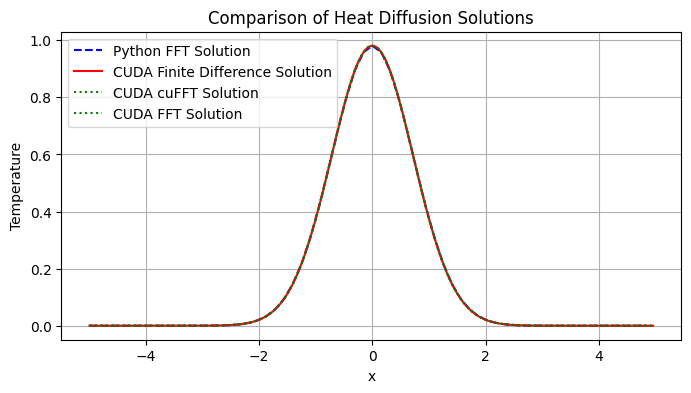

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Load CUDA results from file
cuda_results = np.loadtxt("heat_equation_cuda_result.txt")
x_cuda, u_cuda = cuda_results[:, 0], cuda_results[:, 1]

# Load CUDA FFT results from file
cuda_cufft_results = np.loadtxt("heat_equation_cuda_cufft_result.txt")
x_cuda_cufft, u_cuda_cufft = cuda_cufft_results[:, 0], cuda_cufft_results[:, 1]


# Load CUDA FFT results from file
cuda_fft_results = np.loadtxt("heat_equation_cuda_fft_result.txt")
x_cuda_fft, u_cuda_fft = cuda_fft_results[:, 0], cuda_fft_results[:, 1]

# Define parameters (match CUDA implementation)
N = 64
L = 10.0
alpha = 0.01
dx = L / N
x = np.linspace(-L/2, L/2, N, endpoint=False)
t_final = 1.0

# Initial Condition: Gaussian Heat Distribution
u0 = np.exp(-x**2)

# Compute FFT-based solution in Python
u0_hat = np.fft.fftshift(np.fft.fft(u0))  # Forward FFT
k_vals = np.fft.fftshift(np.fft.fftfreq(N, d=dx) * 2 * np.pi)  # Wavenumbers
k2 = k_vals**2
u_hat_final = u0_hat * np.exp(-alpha * k2 * t_final)  # Time evolution
u_final = np.real(np.fft.ifft(np.fft.ifftshift(u_hat_final)))  # Inverse FFT

# Plot comparison
plt.figure(figsize=(8, 4))
plt.plot(x, u_final, label="Python FFT Solution", linestyle="dashed", color="blue")
plt.plot(x_cuda, u_cuda, label="CUDA Finite Difference Solution", linestyle="solid", color="red")
plt.plot(x_cuda_cufft, u_cuda_cufft, label="CUDA cuFFT Solution", linestyle="dotted", color="green")
plt.plot(x_cuda_fft, u_cuda_fft, label="CUDA FFT Solution", linestyle="dotted", color="green")
plt.xlabel("x")
plt.ylabel("Temperature")
plt.title("Comparison of Heat Diffusion Solutions")
plt.legend()
plt.grid()
plt.show()
